In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["figure.dpi"] = 100
np.set_printoptions(precision=3, suppress=True)
import pandas as pd

In [2]:
df = pd.read_csv("../homeworks/homework2_data.csv", na_values=[9999, 99999, 999999, 9999999])

In [3]:
df.head()

,recid,boro,uf1_1,uf1_2,uf1_3,uf1_4,uf1_5,uf1_6,uf1_7,uf1_8,...,hflag4,hflag18,uf52h_h,uf52h_a,uf52h_b,uf52h_c,uf52h_d,uf52h_e,uf52h_f,uf52h_g
0,1,1,9,9,9,9,1,9,9,9,...,0,0,0,0,0,0,0,0,0,0
1,1,1,9,9,9,9,1,9,9,9,...,0,0,1,1,1,0,0,0,0,0
2,1,1,9,9,9,9,1,9,9,9,...,0,0,1,1,1,0,1,0,1,0
3,1,1,9,9,9,9,1,9,9,9,...,0,0,0,0,0,0,0,0,0,0
4,1,1,9,9,9,9,1,9,9,9,...,0,0,1,0,0,0,1,0,0,0


In [4]:
no_rent = df.uf17.isnull()

In [5]:
no_rent.value_counts()

False    10229
True      5113
Name: uf17, dtype: int64

In [6]:
df_rent = df[~no_rent]

In [7]:
rent = df_rent.uf17
data = df_rent.drop("uf17", axis=1)
data = data.drop("race1", axis=1)  # really weirdly encoded, also we don't need it!

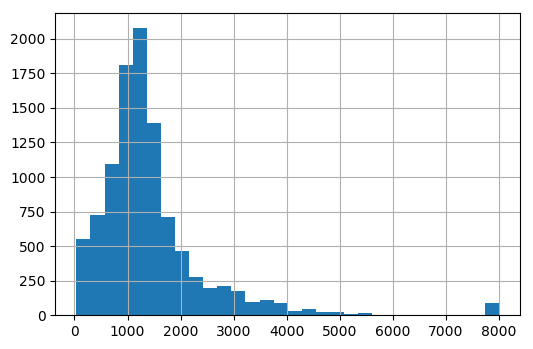

In [8]:
rent.hist(bins=30)

In [9]:
non_const_columns = data.var(axis=0) > 0

In [10]:
data_ = data[data.columns[non_const_columns]]

In [11]:
data_.shape

(10229, 174)

In [12]:
from sklearn.model_selection import train_test_split
data_train, data_test, rent_train, rent_test = train_test_split(data_, rent, random_state=1)

In [13]:
counts = np.array([len(data_train[col].value_counts()) for col in data_train.columns])

In [14]:
data_train[data_train.columns[counts > 10]].head()

,uf43,sc51,sc52,sc110,sc111,sc112,sc113,uf48,uf12,uf13,...,uf37,uf38,uf39a,uf40,cd,uf30,uf29,fw,chufw,seqno
346,46,3,2,99,11,11,11,12,NaN,NaN,...,NaN,NaN,999999,NaN,2,867.0,759.0,239.47278,99143898,255616
9064,24,6,1,1,7,7,7,12,NaN,NaN,...,NaN,NaN,999999,NaN,6,405.0,405.0,211.41603,41741961,74796
897,41,11,2,99,11,11,11,11,90.0,36.0,...,NaN,NaN,999999,NaN,5,1010.0,1010.0,225.35612,86950130,332736
4818,31,4,1,7,20,20,20,3,NaN,NaN,...,NaN,NaN,999999,NaN,13,103.0,103.0,179.96685,140526933,622803
5223,57,4,4,99,12,12,12,12,115.0,25.0,...,NaN,NaN,999999,NaN,14,274.0,243.0,172.53349,66491597,232986


In [15]:
raw_variables = pd.read_excel("../homeworks/homework2_variable_description.xls", skiprows=4)
# drop repeats of the header
raw_variables = raw_variables[raw_variables['Variable Name'] != "Variable Name"]

variables = raw_variables.dropna(subset=['Variable Name'])

# sometimes two variable names correspond to the same item
# the first variable starts with rec and they are in directly adjacent rows
for i, row in variables.iterrows():
    if i - 1 in variables.index:
        # the row above also has a variable name
        row_above = variables.loc[i-1]
        if row_above['Variable Name'].startswith("REC"):
            # this is one of the culprits
            #print(row)
            #print(row_above)
            # replace UF row with REC row
            variables.loc[i]['Item Name'] = variables.loc[i-1]['Item Name']

mask = variables['Item Name'].isnull()
variables = variables.copy()  # variables is a slice of a dataframe and not a dataframe before this.
variables['Item Name'][mask] = variables['Code and Description'][mask]
variables['Variable Name'] = variables['Variable Name'].str.strip(",").replace("SEX/HHR2", "HHR2")

variables = variables.set_index(variables['Variable Name'].str.lower())
variables.loc['uf43']['Item Name'] = variables.loc['hhr3t']['Item Name'] # manual fix ...
item_name = variables['Item Name']

source_codes = raw_variables.dropna(subset=['Source Code']).copy()
source_codes['Source Code'] = source_codes['Source Code'].astype("str").str.lstrip("0")
source_codes = source_codes.drop_duplicates(subset=["Source Code"])
sc_reindex = source_codes.set_index("sc" + source_codes['Source Code'])

source_code_series = sc_reindex['Item Name']

In [16]:
feature_mapping = {}
for c in data_.columns:
    if c in item_name.index:
        feature_mapping[c] = c + " " + item_name.loc[c]
    elif c in source_code_series.index:
        feature_mapping[c] = c + " " + source_code_series.loc[c]
    else:
        print(c)
feature_mapping['seqno'] = "seqno"

seqno


In [17]:
feature_mapping

{'boro': 'boro Borough',
 'cd': 'cd Sub-borough Area',
 'chufw': 'chufw Aggregate Persons Weight',
 'flg_ag1': "flg_ag1 Householder's age",
 'flg_hs1': 'flg_hs1 Householder of Spanish/Hispanic',
 'flg_rc1': "flg_rc1 Householder's  Race",
 'flg_sx1': "flg_sx1 Householder's sex",
 'fw': 'fw Household Weight',
 'hflag10': 'hflag10 Gas - Monthly Cost',
 'hflag11': 'hflag11 Water and Sewer - Yearly Cost',
 'hflag12': 'hflag12 Other Fuels - Yearly Cost',
 'hflag14': 'hflag14 Complete Plumbing Facilities',
 'hflag16': 'hflag16 Kitchen Facilities',
 'hflag18': 'hflag18 Monthly Rent Paid by Government',
 'hflag2': 'hflag2 Year Moved In',
 'hflag3': 'hflag3 Number of Rooms/Bedrooms',
 'hflag4': 'hflag4 Monthly Contract Rent',
 'hflag6': 'hflag6 Stories in Building',
 'hflag7': 'hflag7 Type of Heating Fuel',
 'hflag9': 'hflag9 Electricity - Monthly Cost',
 'hflag91': 'hflag91 Combined Gas/Electricity - Monthly Cost',
 'hhr2': "hhr2 Householder's Sex",
 'hhr5': 'hhr5 Origin',
 'new_csr': 'new_csr 

In [18]:
data_desc = data_.rename_axis(feature_mapping, axis=1)
data_train, data_test, rent_train, rent_test = train_test_split(data_desc, rent, random_state=1)

In [19]:
pd.Series(counts, index=data_desc.columns).sort_values(ascending=False)[:40]

seqno                                        7671
chufw Aggregate Persons Weight               5267
uf42 Total Household Income Recode           2431
fw Household Weight                          2232
uf26 Monthly Gross Rent                      1875
uf17a Out of Pocket Rent                     1326
uf28 Monthly Gross Rent per Room             1299
uf34 Household Income from Wages,            1007
uf27 Monthly Contract Rent Per                943
uf30 Monthly Gross Rent as Percent of         920
uf29 Monthly Contract Rent as                 897
uf37 Household Income from Social             536
uf38 Household Income from                    276
uf39a Income Flag                             181
uf40 Household Income from                    181
uf12 Monthly Cost                             172
uf35 Household Income from                    151
uf14 Combined Gas/Electricity                 144
uf13 Monthly Cost                             114
uf36 Household Income from Interest,          110


In [20]:
drop_continuous_etc = counts >= 20

data_discrete = data_desc.drop(data_desc.columns[drop_continuous_etc], axis=1)
data_train, data_test, rent_train, rent_test = train_test_split(data_discrete, rent, random_state=1)

In [21]:
data_desc.shape

(10229, 174)

In [22]:
data_discrete.shape

(10229, 142)

In [23]:
data_discrete.isnull().any().any()

False

In [24]:
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(data_train, rent_train.values)
inds = np.argsort(mi)

/home/andy/checkout/scikit-learn/sklearn/utils/validation.py:427: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(0, 142)

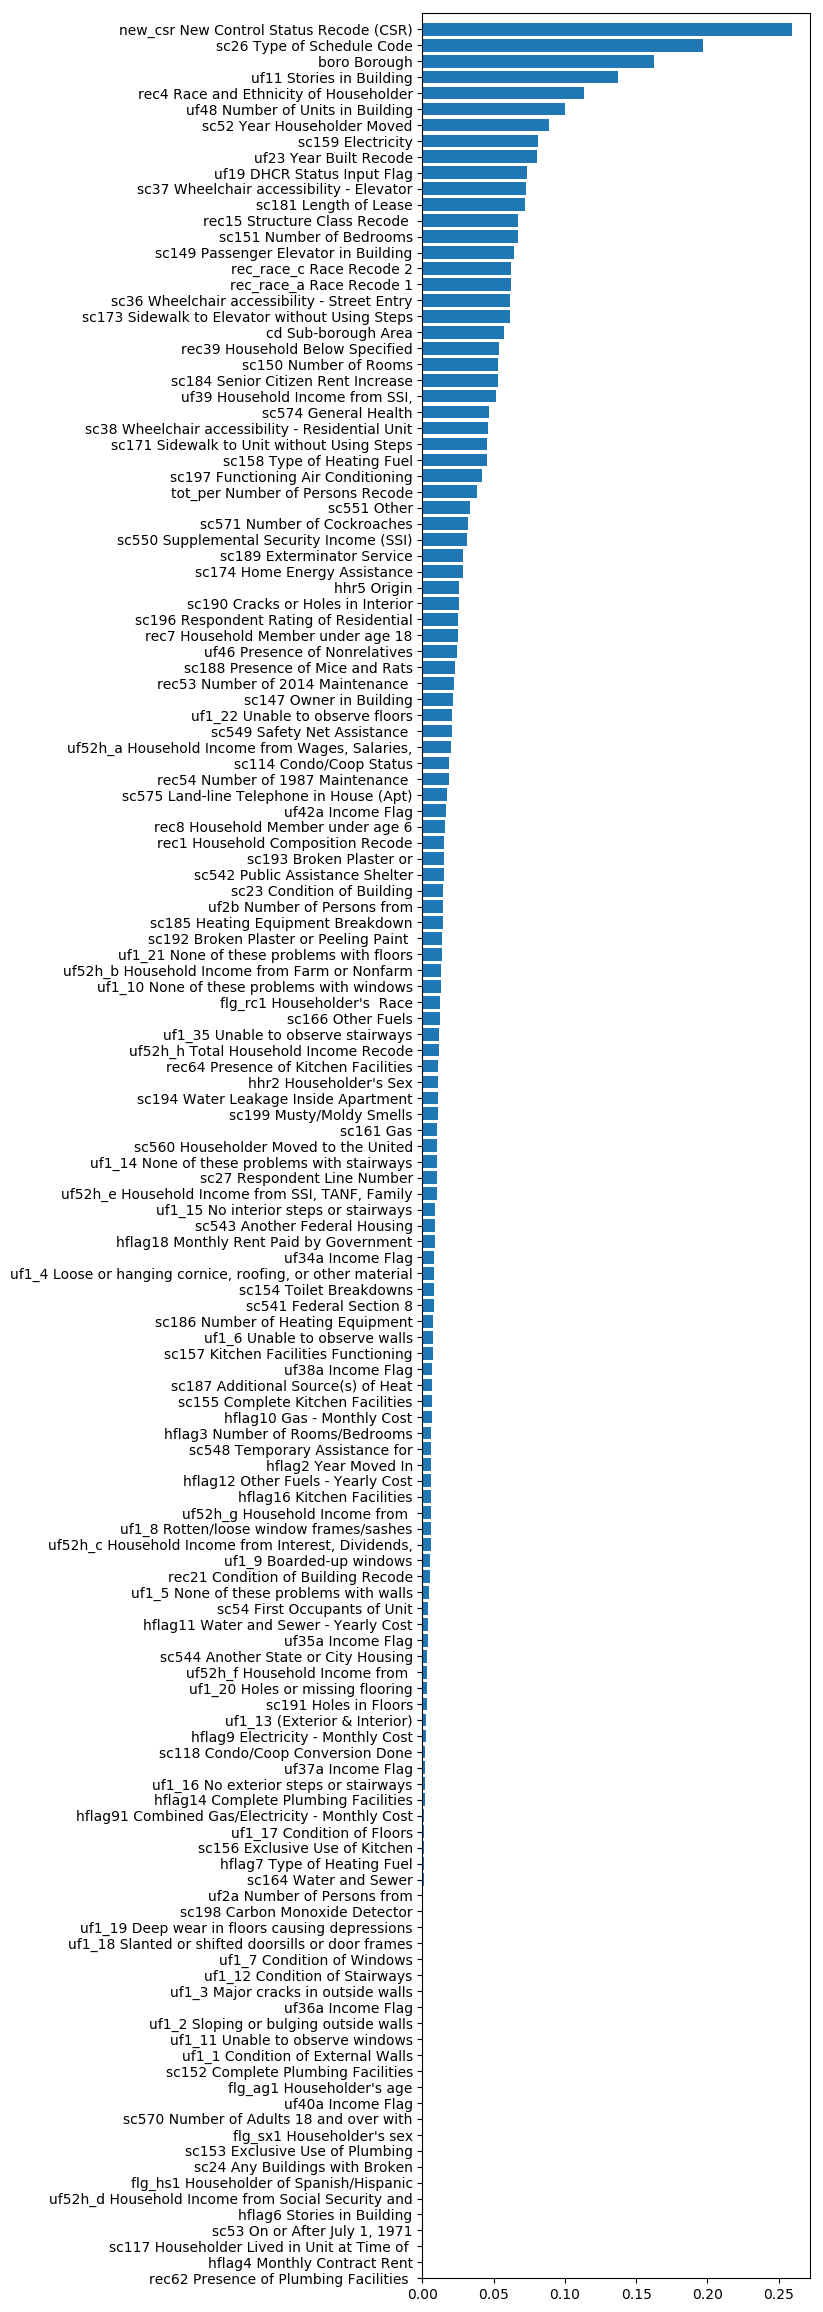

In [25]:
plt.figure(figsize=(5, 30))
plt.barh(np.arange(len(mi)), np.log(mi[inds] + 1))
plt.yticks(np.arange(len(mi)), data_train.columns[inds])
plt.ylim(0, len(mi))

In [26]:
def good_feature(x):
    bad_words = ["Household", "Rent", "Cost", "Race", "Moved In", "Origin", "sc5", "tot_per", "Lease"]
    for word in bad_words:
        if word in x:
            return False
    
    if x.startswith("uf") and not x.startswith("uf1"):
        return False
    
    return True
    
non_renter_columns = [x for x in data_train.columns if good_feature(x)]
len(non_renter_columns)

80

In [27]:
sorted(non_renter_columns)

['boro Borough',
 'cd Sub-borough Area',
 'hflag14 Complete Plumbing Facilities',
 'hflag16 Kitchen Facilities',
 'hflag3 Number of Rooms/Bedrooms',
 'hflag6 Stories in Building',
 'hflag7 Type of Heating Fuel',
 'new_csr New Control Status Recode (CSR)',
 'rec15 Structure Class Recode ',
 'rec21 Condition of Building Recode',
 'rec53 Number of 2014 Maintenance ',
 'rec54 Number of 1987 Maintenance ',
 'rec62 Presence of Plumbing Facilities ',
 'rec64 Presence of Kitchen Facilities',
 'sc114 Condo/Coop Status',
 'sc118 Condo/Coop Conversion Done',
 'sc147 Owner in Building',
 'sc149 Passenger Elevator in Building',
 'sc150 Number of Rooms',
 'sc151 Number of Bedrooms',
 'sc152 Complete Plumbing Facilities',
 'sc153 Exclusive Use of Plumbing',
 'sc154 Toilet Breakdowns',
 'sc155 Complete Kitchen Facilities',
 'sc156 Exclusive Use of Kitchen',
 'sc157 Kitchen Facilities Functioning',
 'sc158 Type of Heating Fuel',
 'sc159 Electricity',
 'sc161 Gas',
 'sc164 Water and Sewer',
 'sc166 Othe

In [28]:
data_non_renter = data_discrete[non_renter_columns]
data_train, data_test, rent_train, rent_test = train_test_split(data_non_renter, rent, random_state=1)

In [29]:
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(data_train, rent_train)

/home/andy/checkout/scikit-learn/sklearn/utils/validation.py:427: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


(0, 80)

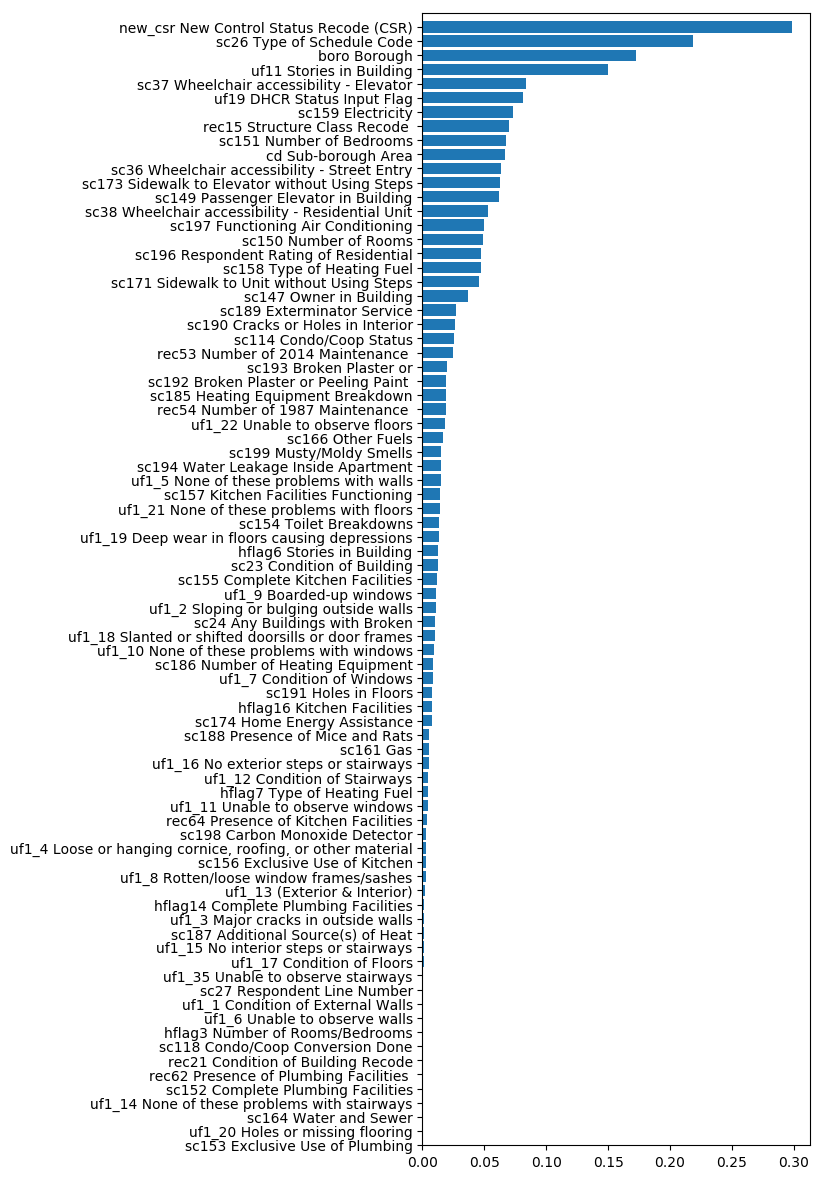

In [30]:
inds = np.argsort(mi)
plt.figure(figsize=(5, 15))
plt.barh(np.arange(len(mi)), mi[inds])
plt.yticks(np.arange(len(mi)), data_train.columns[inds])
plt.ylim(0, len(mi))

In [31]:
data_train_dummies = pd.get_dummies(data_train, columns=data_train.columns)

(0, 50)

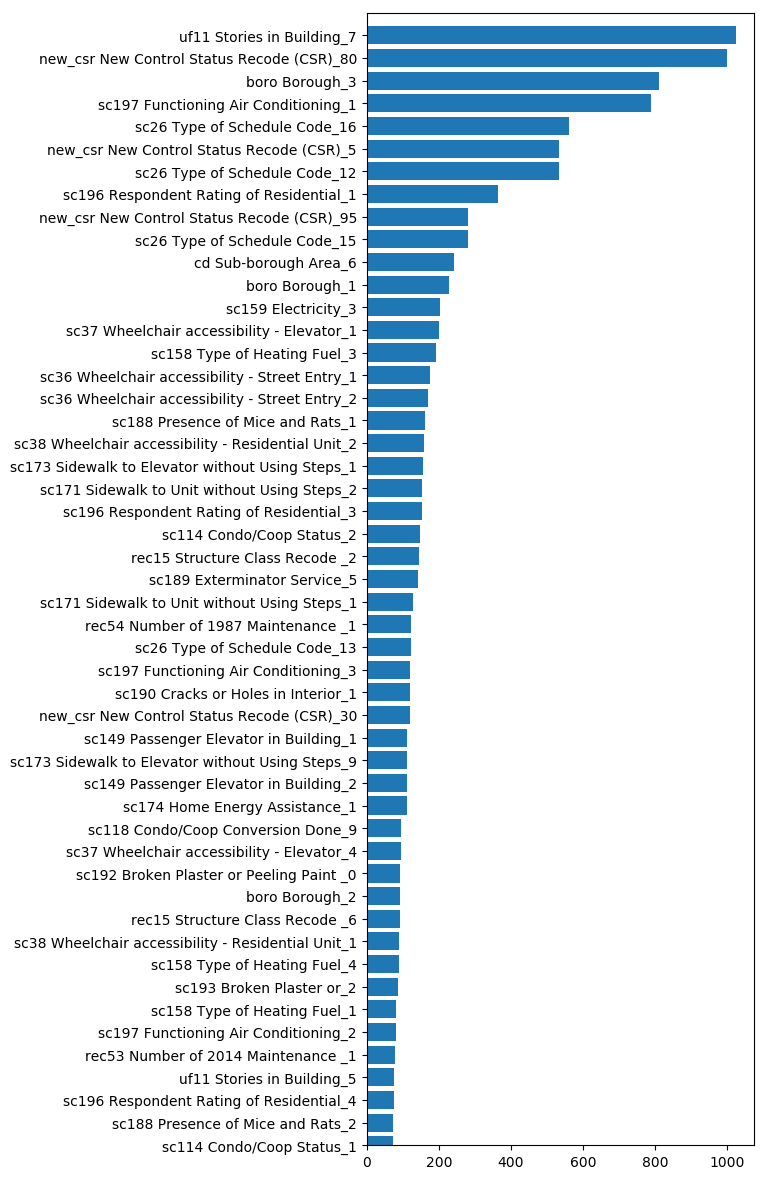

In [32]:
from sklearn.feature_selection import f_regression
F, p = f_regression(data_train_dummies, rent_train)

top_n = 50
inds = np.argsort(F)
plt.figure(figsize=(5, 15))
plt.barh(np.arange(top_n), F[inds[-top_n:]])
plt.yticks(np.arange(top_n), data_train_dummies.columns[inds[-top_n:]])
plt.ylim(0, top_n)

In [33]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score

cross_val_score(RidgeCV(alphas=np.logspace(-3, 3, 7)), data_train_dummies, rent_train, cv=5)

array([ 0.491,  0.461,  0.533,  0.494,  0.513])

In [34]:
ridge = RidgeCV(alphas=np.logspace(-3, 3, 7)).fit(data_train_dummies, rent_train)
ridge.alpha_

10.0

(0, 50)

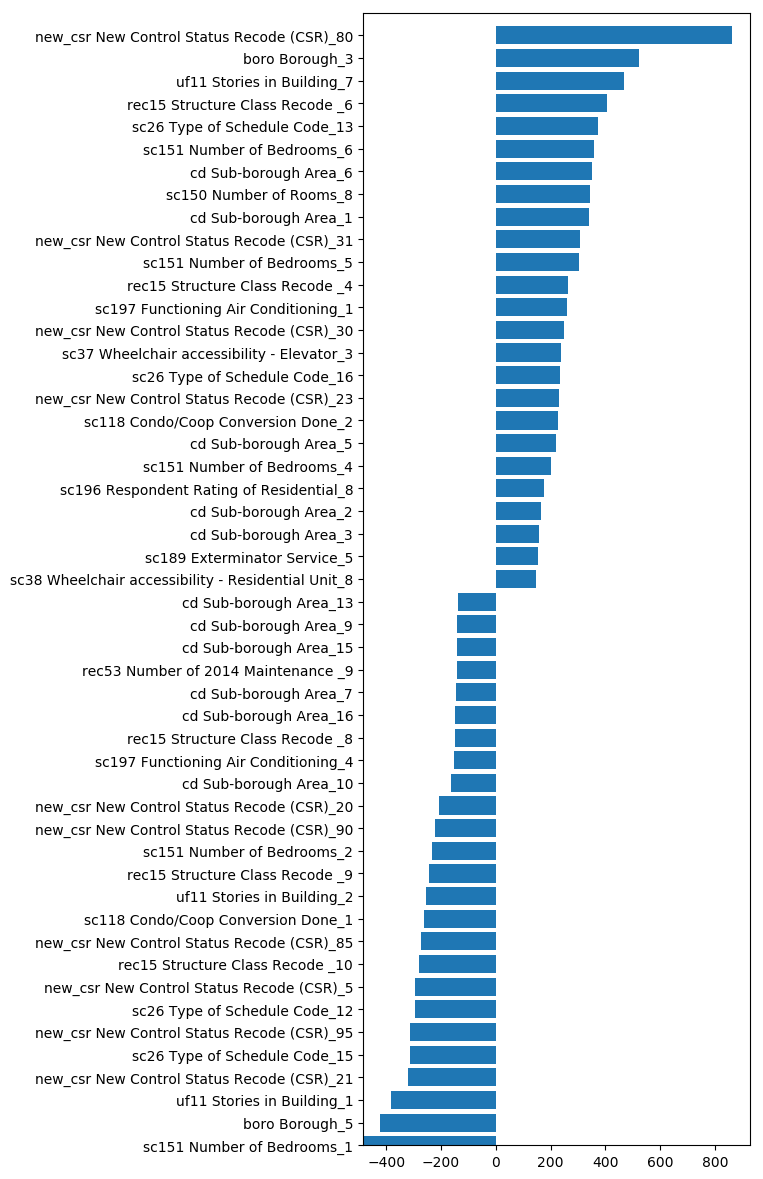

In [35]:
top_n = 50
coef = ridge.coef_
inds = np.argsort(coef)
inds = np.hstack([inds[:top_n // 2], inds[-top_n//2:]])
plt.figure(figsize=(5, 15))
plt.barh(np.arange(top_n), coef[inds])
plt.yticks(np.arange(top_n), data_train_dummies.columns[inds])
plt.ylim(0, top_n)

In [36]:
data_train_dummies.columns[inds[-1]]

'new_csr New Control Status Recode (CSR)_80'

In [37]:
data_train["new_csr New Control Status Recode (CSR)"].value_counts()

80    2766
30    2640
31     917
5      633
95     316
85     169
21     116
90      96
20       8
23       7
22       3
Name: new_csr New Control Status Recode (CSR), dtype: int64

In [38]:
codes = """01=Owner occupied conventional
02=Owner occupied private cooperative
05=Public housing
12=Owner occupied condo
20=Article 4 or 5 building
21=HUD regulated
22=Loft Board regulated building
23=Municipal Loan Program
30=Stabilized pre 1947
31=Stabilized post 1947
80=Other rental
85=Mitchell Lama rental
86=Mitchell Lama cooperative
87=Mitchell Lama type cooperative
90=Controlled
95=In Rem"""

In [39]:
code_dict = {int(code.split("=")[0]): code.split("=")[1] for code in codes.split("\n")}
code_dict

{1: 'Owner occupied conventional',
 2: 'Owner occupied private cooperative',
 5: 'Public housing',
 12: 'Owner occupied condo',
 20: 'Article 4 or 5 building',
 21: 'HUD regulated',
 22: 'Loft Board regulated building',
 23: 'Municipal Loan Program',
 30: 'Stabilized pre 1947',
 31: 'Stabilized post 1947',
 80: 'Other rental',
 85: 'Mitchell Lama rental',
 86: 'Mitchell Lama cooperative',
 87: 'Mitchell Lama type cooperative',
 90: 'Controlled',
 95: 'In Rem'}

In [40]:
data_train["new_csr New Control Status Recode (CSR)"].value_counts().rename_axis(code_dict, axis=0)

Other rental                     2766
Stabilized pre 1947              2640
Stabilized post 1947              917
Public housing                    633
In Rem                            316
Mitchell Lama rental              169
HUD regulated                     116
Controlled                         96
Article 4 or 5 building             8
Municipal Loan Program              7
Loft Board regulated building       3
Name: new_csr New Control Status Recode (CSR), dtype: int64

In [41]:
groups = rent.groupby(data_train["new_csr New Control Status Recode (CSR)"])

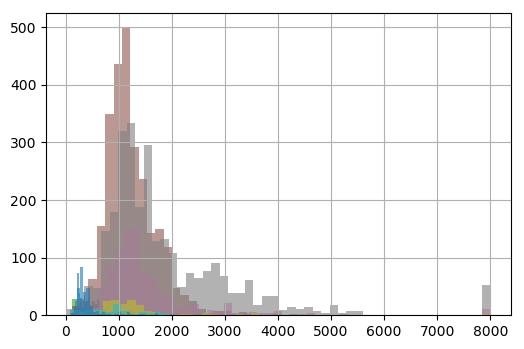

In [42]:
hists = groups.hist(bins=50, alpha=.6)

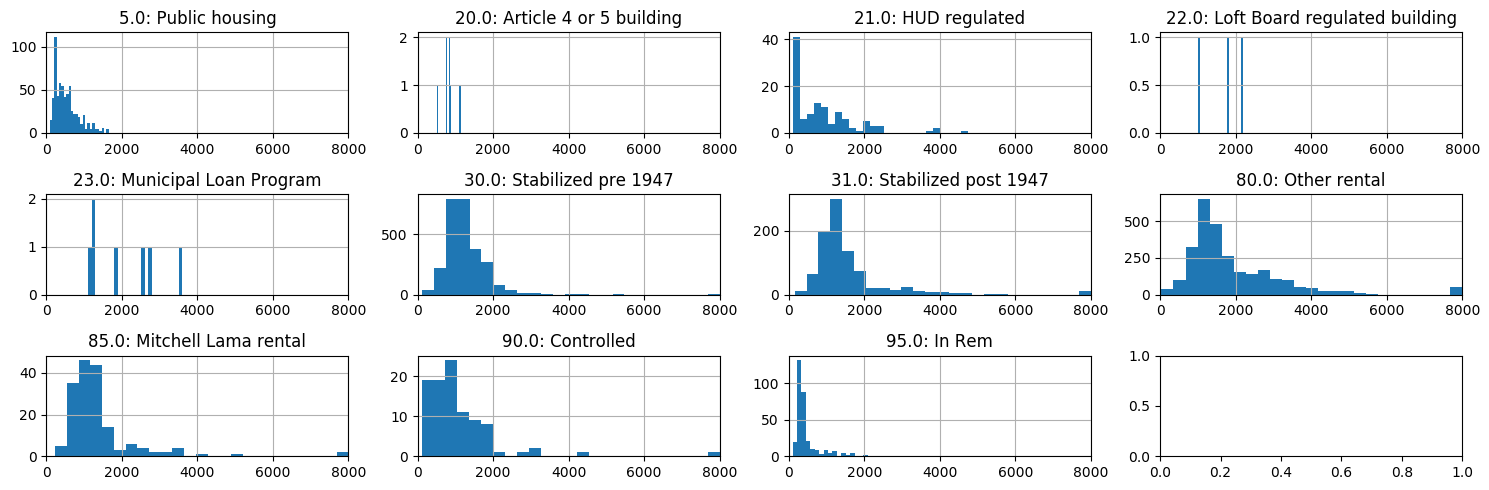

In [43]:
fig, axes = plt.subplots(3, len(groups) // 3 + 1, figsize=(15, 5))
for ax, (val, group) in zip(axes.ravel(), groups):
    group.hist(ax=ax, bins=25)
    ax.set_xlim(0, 8000)
    ax.set_title("{}: {}".format(val, code_dict[val]))

    plt.tight_layout()

In [44]:
not_stabilized = data_non_renter["new_csr New Control Status Recode (CSR)"] == 80
data_not_stabilized = data_non_renter[not_stabilized]
rent_not_stabilized = rent[not_stabilized]

71

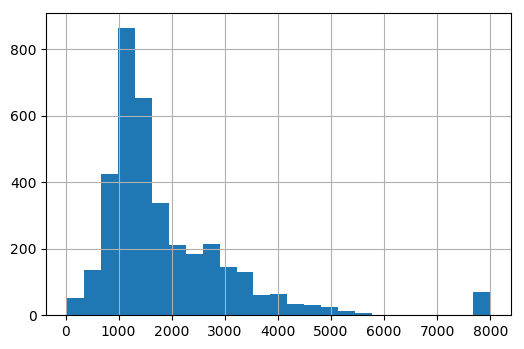

In [45]:
rent_not_stabilized.hist(bins=25)
np.sum(rent_not_stabilized == 7999)

In [46]:
data_dummies = pd.get_dummies(data_not_stabilized, columns=data_not_stabilized.columns)
data_train_dummies, data_test_dummies, rent_train, rent_test = train_test_split(
    data_dummies, rent_not_stabilized, random_state=1)

In [47]:
cross_val_score(RidgeCV(alphas=np.logspace(-3, 3, 7)), data_train_dummies, rent_train, cv=5)

array([ 0.523,  0.63 ,  0.549,  0.592,  0.571])

In [48]:
cross_val_score(RidgeCV(alphas=np.logspace(-3, 3, 7)), data_train_dummies[rent_train != 7999],
                rent_train[rent_train != 7999], cv=5)

array([ 0.595,  0.647,  0.581,  0.646,  0.619])

In [49]:
mse_all = cross_val_score(RidgeCV(alphas=np.logspace(-3, 3, 7)), data_train_dummies, rent_train, cv=5, scoring="mean_squared_error")
np.mean(mse_all)

/home/andy/checkout/scikit-learn/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/andy/checkout/scikit-learn/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/andy/checkout/scikit-learn/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/andy/checkout/scikit-learn/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/andy/checkout/scikit-learn/sklearn/metrics/scorer.py:99: DeprecationWa

-747172.31202591234

In [50]:
mse_bottom = cross_val_score(RidgeCV(alphas=np.logspace(-3, 3, 7)), data_train_dummies[rent_train != 7999], rent_train[rent_train != 7999],
                          cv=5, scoring="mean_squared_error")
np.mean(mse_bottom)

/home/andy/checkout/scikit-learn/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/andy/checkout/scikit-learn/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/andy/checkout/scikit-learn/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/andy/checkout/scikit-learn/sklearn/metrics/scorer.py:99: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/andy/checkout/scikit-learn/sklearn/metrics/scorer.py:99: DeprecationWa

-393640.20515380742

In [51]:
data_not_top = data_not_stabilized[rent_not_stabilized != 7999]
rent_not_top = rent_not_stabilized[rent_not_stabilized != 7999]
data_dummies = pd.get_dummies(data_not_top, columns=data_not_top.columns, prefix_sep="$")
data_train_dummies, data_test_dummies, data_train, data_test, rent_train, rent_test = train_test_split(
    data_dummies, data_not_top, rent_not_top, random_state=1)

In [52]:
rent_not_top.shape

(3587,)

In [53]:
ridge = RidgeCV(alphas=np.logspace(-3, 3, 7)).fit(data_train_dummies, rent_train)
ridge.alpha_

10.0

(0, 50)

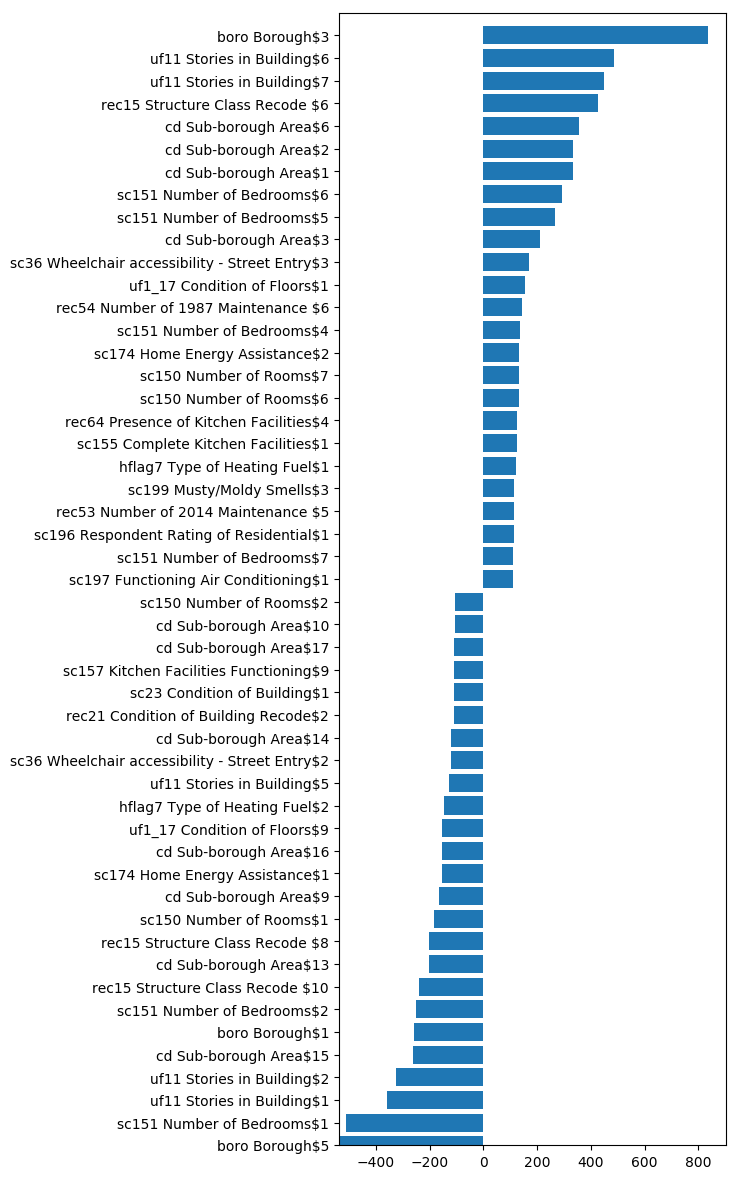

In [54]:
top_n = 50
coef = ridge.coef_
inds = np.argsort(coef)
inds = np.hstack([inds[:top_n // 2], inds[-top_n//2:]])
plt.figure(figsize=(5, 15))
plt.barh(np.arange(top_n), coef[inds[-top_n:]])
plt.yticks(np.arange(top_n), data_train_dummies.columns[inds[-top_n:]])
plt.ylim(0, top_n)

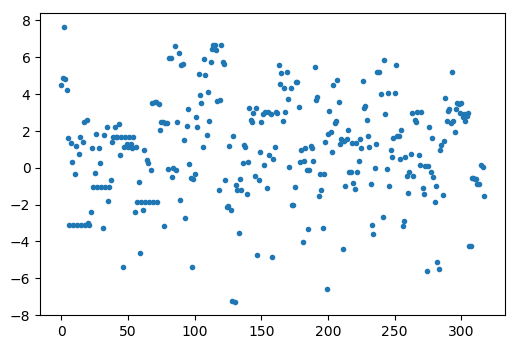

In [55]:
F, p = f_regression(data_train_dummies, rent_train)
plt.plot(np.log(F), ".")

In [56]:
series = pd.Series(F, index=data_train_dummies.columns)
grouped_f = series.groupby(lambda x: x.split("$")[0]).sum()

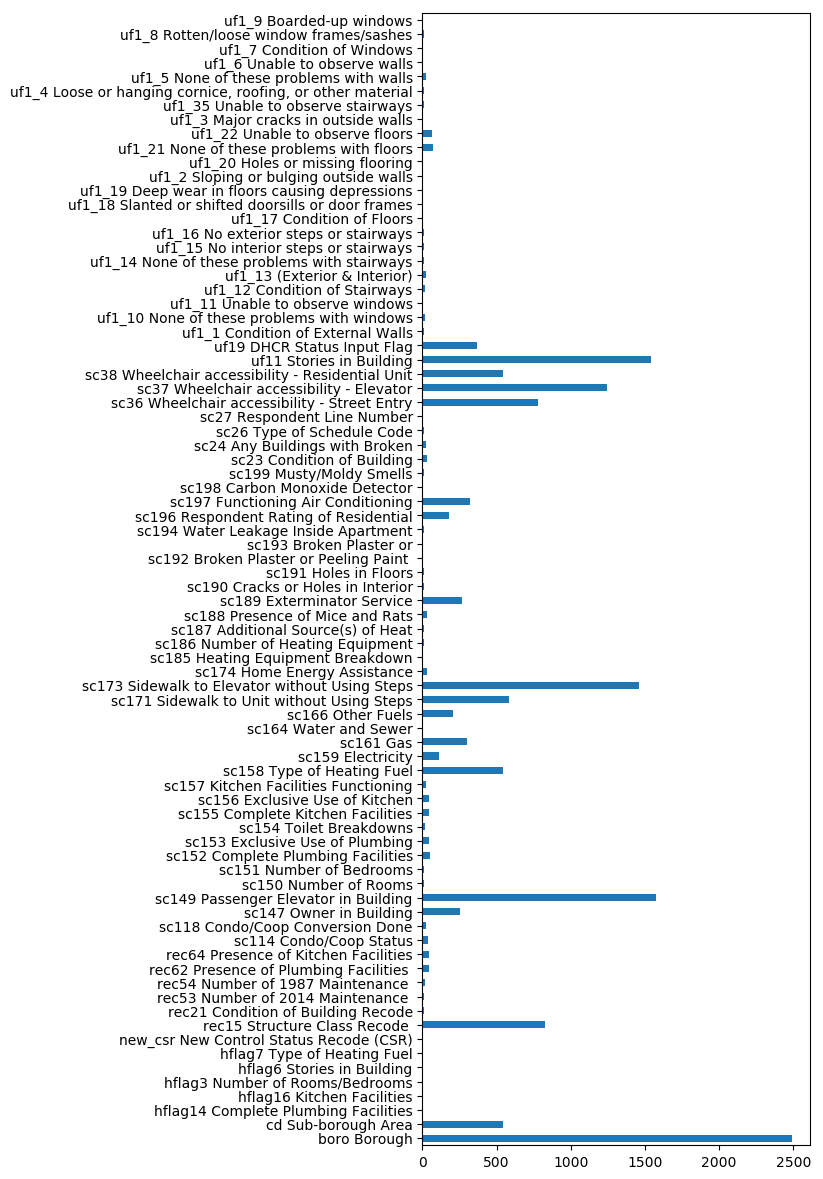

In [57]:
plt.figure(figsize=(5, 15))
grouped_f.plot(kind="barh")

In [58]:
from sklearn.ensemble import RandomForestRegressor
cross_val_score(RandomForestRegressor(max_depth=20, n_estimators=100, n_jobs=3), data_train_dummies, rent_train, cv=5)


array([ 0.592,  0.609,  0.62 ,  0.676,  0.663])

In [59]:
rf = RandomForestRegressor(max_depth=20, n_estimators=100, n_jobs=3).fit(data_train_dummies, rent_train)

In [60]:
mi = mutual_info_regression(data_train, rent_train)

/home/andy/checkout/scikit-learn/sklearn/utils/validation.py:427: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [61]:
importances = pd.DataFrame({'fi':rf.feature_importances_, 'f': F}, index=data_train_dummies.columns)
grouped_fi = importances.groupby(lambda x: x.split("$")[0]).sum()
# normalize scales
grouped_fi['f'] /= grouped_fi.f.sum()
grouped_fi['fi'] /= grouped_fi.fi.sum()
grouped_fi['mi'] = mi / mi.sum()
grouped_fi.sort_values(by='fi', inplace=True)

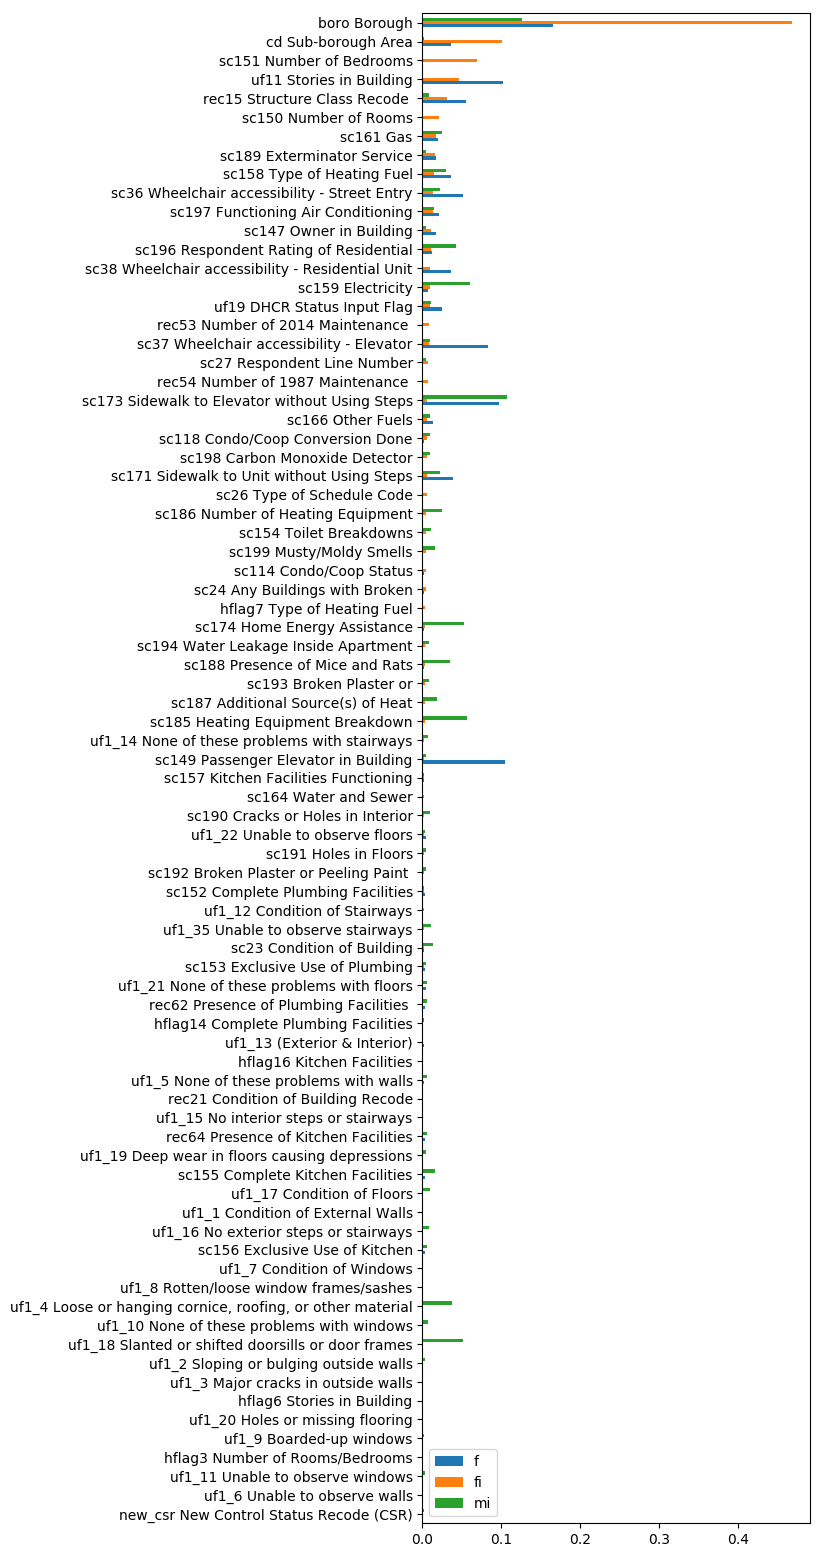

In [62]:
plt.figure(figsize=(5, 20))
grouped_fi.plot(kind='barh', ax=plt.gca())

In [63]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold, SelectPercentile
from sklearn.pipeline import make_pipeline 

pipe = make_pipeline(SelectPercentile(score_func=f_regression, percentile=30), PolynomialFeatures(interaction_only=True), VarianceThreshold(),
                     RidgeCV(alphas=np.logspace(-3, 3, 7)))
cross_val_score(pipe, data_train_dummies, rent_train, cv=5)

array([ 0.523,  0.581,  0.551,  0.624,  0.591])

In [64]:
pipe = make_pipeline(SelectPercentile(score_func=f_regression, percentile=10), PolynomialFeatures(interaction_only=True),
                     VarianceThreshold(), RidgeCV(alphas=np.logspace(-3, 3, 7)))
cross_val_score(pipe, data_train_dummies, rent_train, cv=10)

array([ 0.481,  0.443,  0.527,  0.539,  0.492,  0.507,  0.586,  0.547,
        0.536,  0.59 ])

In [65]:
pipe = make_pipeline(SelectPercentile(score_func=f_regression, percentile=30), PolynomialFeatures(interaction_only=True),
                     RidgeCV(alphas=np.logspace(-3, 3, 7)))
cross_val_score(pipe, data_train_dummies, rent_train, cv=10)

array([ 0.52 ,  0.511,  0.599,  0.596,  0.53 ,  0.563,  0.626,  0.615,
        0.546,  0.629])

In [66]:
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(SelectPercentile(score_func=f_regression, percentile=50), PolynomialFeatures(interaction_only=True), VarianceThreshold(),
                     RidgeCV(alphas=np.logspace(-3, 3, 7)))
param_grid = {'selectpercentile__percentile': [1, 5, 10, 20, 30, 50], 'polynomialfeatures__degree': [1, 2]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(data_train_dummies, rent_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('selectpercentile', SelectPercentile(percentile=50,
         score_func=<function f_regression at 0x7f4994dc1d08>)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=True)), ('variancethreshold', VarianceThreshold(threshold=0.0)), ('ridgecv', RidgeCV(al...None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'selectpercentile__percentile': [1, 5, 10, 20, 30, 50], 'polynomialfeatures__degree': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [67]:
grid.best_score_

0.58357146579460417

In [68]:
grid.best_params_

{'polynomialfeatures__degree': 2, 'selectpercentile__percentile': 50}

In [69]:
grid.best_estimator_.named_steps['ridgecv'].alpha_

100.0

In [70]:
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge

pipe = make_pipeline(SelectPercentile(score_func=f_regression, percentile=50), PolynomialFeatures(interaction_only=True), VarianceThreshold(),
                     Ridge(alpha=100))
pred = cross_val_predict(pipe, data_train_dummies, rent_train, cv=5)

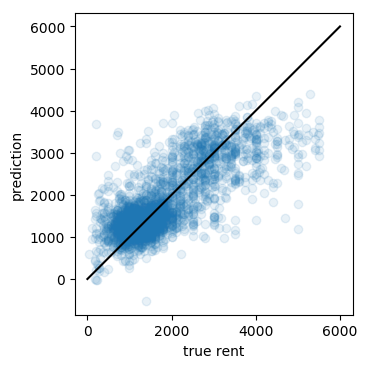

In [71]:
plt.scatter(rent_train, pred, alpha=.1)
plt.gca().set_aspect("equal")
plt.plot([0, 6000], [0, 6000], c='k')
plt.xlabel("true rent")
plt.ylabel("prediction")

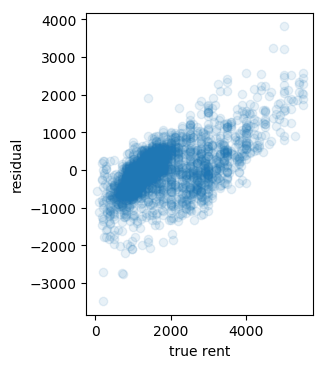

In [72]:
plt.scatter(rent_train, rent_train - pred, alpha=.1)
plt.gca().set_aspect("equal")
plt.xlabel("true rent")
plt.ylabel("residual")

In [74]:
pipe = make_pipeline(SelectPercentile(score_func=f_regression, percentile=50), PolynomialFeatures(interaction_only=True), VarianceThreshold(),
                     Ridge(alpha=1))
pred = cross_val_predict(pipe, data_train_dummies, rent_train, cv=5)

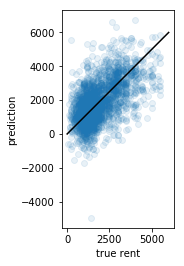

In [75]:
plt.scatter(rent_train, pred, alpha=.1)
plt.gca().set_aspect("equal")
plt.plot([0, 6000], [0, 6000], c='k')
plt.xlabel("true rent")
plt.ylabel("prediction")

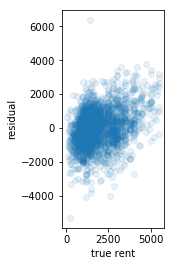

In [76]:
plt.scatter(rent_train, rent_train - pred, alpha=.1)
plt.gca().set_aspect("equal")
plt.xlabel("true rent")
plt.ylabel("residual")

In [78]:
from sklearn.linear_model import LassoLarsCV

pipe = make_pipeline(SelectPercentile(score_func=f_regression, percentile=50), PolynomialFeatures(interaction_only=True), VarianceThreshold(),
                     LassoLarsCV())
param_grid = {'selectpercentile__percentile': [1, 5, 10, 20, 30, 50], 'polynomialfeatures__degree': [1, 2]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(data_train_dummies, rent_train)

/home/andy/checkout/scikit-learn/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.482e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 1.054e-08
  ConvergenceWarning)
/home/andy/checkout/scikit-learn/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=3.482e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 3.799e-08
  ConvergenceWarning)
/home/andy/checkout/scikit-learn/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.741e+00, with an active set of 5 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/home/andy/checkout/scikit-learn/sklearn/linear_model/least_angle.py:309:

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('selectpercentile', SelectPercentile(percentile=50,
         score_func=<function f_regression at 0x7f4994dc1d08>)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=True)), ('variancethreshold', VarianceThreshold(th..._n_alphas=1000, n_jobs=1,
      normalize=True, positive=False, precompute='auto', verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'selectpercentile__percentile': [1, 5, 10, 20, 30, 50], 'polynomialfeatures__degree': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)